# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Install packages and import libraries

Uncomment and run the following cell to install necessary packages

In [116]:
# TODO: Make a requirements.txt and provide installation instructions
# %conda install seaborn
# %conda update pandas
# %conda install -c conda-forge scikit-learn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import sklearn

%matplotlib inline

# Data Preview

Read in our transformed dataset <b>inputs_pre.csv</b> from [Data Preview and Transform](http://localhost:8888/notebooks/Desktop/Data/udacity-ml-capstone/Data%20Preview%20and%20Transform.ipynb).

In [4]:
inputs_pre = pd.read_csv("data/inputs_pre.csv")
inputs_pre

,start_time,end_time,offer_id,person,amount,reward,gender,age,became_member_on,income
0,0.0,192.0,no_offer,0009655768c64bdeb2e877511632db8f,0.00,NaN,M,33,20170421,72000.0
1,192.0,240.0,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,22.16,0.0,M,33,20170421,72000.0
2,240.0,372.0,no_offer,0009655768c64bdeb2e877511632db8f,0.00,NaN,M,33,20170421,72000.0
3,372.0,432.0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,8.57,0.0,M,33,20170421,72000.0
4,432.0,714.0,no_offer,0009655768c64bdeb2e877511632db8f,96.87,NaN,M,33,20170421,72000.0
...,...,...,...,...,...,...,...,...,...,...
109823,198.0,354.0,no_offer,ffff82501cea40309d5fdd7edcca4a07,96.37,NaN,F,45,20161125,62000.0
109824,354.0,384.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,15.57,2.0,F,45,20161125,62000.0
109825,384.0,414.0,no_offer,ffff82501cea40309d5fdd7edcca4a07,33.12,NaN,F,45,20161125,62000.0
109826,414.0,414.0,2906b810c7d4411798c6938adc9daaa5,ffff82501cea40309d5fdd7edcca4a07,17.55,2.0,F,45,20161125,62000.0


Read in the JSON files.

In [5]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True).rename(columns={"id": "offer_id"})
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get("offer id", x.get("offer_id", np.nan)))
transcript["amount"] = transcript["value"].apply(lambda x: x.get("amount", np.nan))
transcript["reward"] = transcript["value"].apply(lambda x: x.get("reward", np.nan))
transcript.drop(columns="value", inplace=True)
transcript.head()
transcript

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN


# Feature Engineering

We calculate each user's <b>relative</b> <i>membership_length</i> (a more meaningful input) from the date which they <i>became_member_on</i>, and use that column instead.

In [8]:
def calc_membership_len(X):
    X["became_member_on"] = pd.to_datetime(X["became_member_on"], format="%Y%m%d")
    earliest_date = X["became_member_on"].min()
    X["membership_length"] = X["became_member_on"].apply(lambda x: (x - earliest_date).days)
    return X

How long a user has been a member <b>relative to their age</b> could reflect how much Starbucks is a part of the user's lifestyle, which can contribute to their spending patterns.

In [9]:
def calc_norm_membership_len(X):
    # Calculate membership length normalised on age less the minimum age
    X['norm_membership_length'] = (
        (
            X['membership_length'] / 365
        ) / (
            X['age'] - X['age'].min() + 1
        )
    )
    return X

<p>
    Calculate our dependant variable, <i>avg_transaction_less_reward</i>. We hope to maximise the effect size on this metric when pushing offers to users.
</p>
<p>
    Subtract offer <i>reward</i> from the transacted amount, which <u>penalizes pushing offers to users who would have completed the offer anyway</u>. From <i>start_time</i> and <i>end_time</i> of each period, we can calculate the duration. It acts as the denominator for our metric, normalizing our dependant variable across different offer periods.
</p>
<p>
    Note: Some users view an offer then immediately completes them. This is likely to be a desired offer effect. To include them in our input dataset, we manually give it a duration of <b>1 hour</b>. Also, non-influence periods have no <i>reward</i>, which is set arbitrarily to <b>0</b>.
</p>

In [10]:
def calc_duration(X):
    # Length of offer period in days
    X["duration"] = (
        X["end_time"] - X["start_time"]
    ) / 24
    X.loc[X.duration == 0, 'duration'] = 1 / 24
    return X

def calc_dep_var(X):
    # Calculate daily average of transaction less reward
    X["avg_transaction_less_reward"] = (
        (X["amount"] - X["reward"].fillna(0)) / X["duration"]
    )
    return X

There could be some useful association between <i>time_since_prev_transact</i> and our target variable. We expect some cooldown time between users' consumption, which this feature would help to account for. It can be traced from the <b>transcript</b> data.

In [11]:
def calc_time_since_prev_transact(X, transcript=None):
    if transcript is None:
        raise TypeError('missing transcript data argument')
    # For each influence period start time, get from transcript the time the previous transaction took place
    X = pd.merge_asof(
        X.astype({'start_time': 'int64'}).sort_values("start_time"),
        transcript.loc[
            transcript['event'] == 'transaction',
            ["person", "time"]
        ],
        left_on="start_time",
        right_on="time",
        by="person",
        allow_exact_matches=False,
    )
    X['time_since_prev_transact'] = (X['start_time'] - X['time']) / 24
    return X

The offer <i>view_rate</i> and <i>complete_rate</i> is indicative of a user's behavioral pattern when met with offers.

In [12]:
def calc_view_rate(X, transcript=None):
    if transcript is None:
        raise TypeError('missing transcript data argument')
    # Number of offers viewed to user divided by number of offers sent to the user
    received = transcript[transcript.event == 'offer received'].groupby('person')['event'].count()
    viewed = transcript[transcript.event == 'offer viewed'].groupby('person')['event'].count()
    view_rate = (viewed / received).rename('view_rate').fillna(0)
    X = X.merge(view_rate, on='person')
    return X

def calc_complete_rate(X, transcript=None):
    if transcript is None:
        raise TypeError('missing transcript data argument')
    # Number of offers completed by user divided by number of offers sent to the user
    received = transcript[transcript.event == 'offer received'].groupby('person')['event'].count()
    completed = transcript[transcript.event == 'offer completed'].groupby('person')['event'].count()
    complete_rate = (completed / received).rename('complete_rate').fillna(0)
    X = X.merge(complete_rate, on='person')
    return X

From each user's transaction history, the different aggregates (e.g. <i>mean</i>, <i>std</i>, <i>range</i>) of transaction amounts give information about the user's spending pattern.

In [13]:
def calc_transact_aggs(X, transcript=None):
    if transcript is None:
        raise TypeError('missing transcript data argument')
    # Calculate each person's mean transaction amount
    t = transcript[transcript.event == 'transaction'].groupby(
        by='person'
    )['amount'].agg([
        'mean', 
        std,
        'min', 
        'max'
    ])
    t['range'] = t['max'] - t['min']
    t.columns = ['transact_' + col for col in t.columns]
    X = X.merge(t, on='person')
    return X

# Workaround for ddof bug
def std(x): return np.std(x)

We wrap feature creation into a pipeline that can be compactly reused to retrain our models or to transform incoming data into inputs that fit our model.

In [14]:
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers import ArbitraryOutlierCapper
from feature_engine.selection import DropFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

feat_eng_pipe = Pipeline(steps=[
    ('calculate_membership_length', FunctionTransformer(calc_membership_len)),
    ('calculate_normalised_membership_length', FunctionTransformer(calc_norm_membership_len)),
    ('calculate_duration', FunctionTransformer(calc_duration)),
    ('calculate_dependent_variable', FunctionTransformer(calc_dep_var)),
    ('calculate_time_since_previous_transaction', FunctionTransformer(
        calc_time_since_prev_transact, kw_args={'transcript': transcript}
    )),
    ('calculate_view_rate', FunctionTransformer(
        calc_view_rate, kw_args={'transcript': transcript}
    )),
    ('calculate_complete_rate', FunctionTransformer(
        calc_complete_rate, kw_args={'transcript': transcript}
    )),
    ('calculate_transaction_aggregates', FunctionTransformer(
        calc_transact_aggs, kw_args={'transcript': transcript}
    )),
])

inputs_pre = feat_eng_pipe.fit_transform(inputs_pre)

In [17]:
inputs_pre[[
    'membership_length',
    'norm_membership_length',
    'avg_transaction_less_reward', 
    'time_since_prev_transact', 
    'view_rate', 
    'complete_rate', 
    'transact_mean', 
    'transact_std',
    'transact_range',
]]

,membership_length,norm_membership_length,avg_transaction_less_reward,time_since_prev_transact,view_rate,complete_rate,transact_mean,transact_std,transact_range
0,1362,0.233219,0.000000,NaN,0.8,0.6,15.95,6.148297,19.59
1,1362,0.233219,11.080000,NaN,0.8,0.6,15.95,6.148297,19.59
2,1362,0.233219,0.000000,0.50,0.8,0.6,15.95,6.148297,19.59
3,1362,0.233219,3.428000,6.00,0.8,0.6,15.95,6.148297,19.59
4,1362,0.233219,8.244255,0.75,0.8,0.6,15.95,6.148297,19.59
...,...,...,...,...,...,...,...,...,...
106959,1657,0.092647,5.643333,2.00,1.0,0.5,9.31,4.279250,13.70
106960,1657,0.092647,9.985000,0.25,1.0,0.5,9.31,4.279250,13.70
106961,1657,0.092647,4.120000,1.75,1.0,0.5,9.31,4.279250,13.70
106962,1657,0.092647,4.511111,3.00,1.0,0.5,9.31,4.279250,13.70


# Data Exploration

To better grasp how offers are being pushed out and how receptive the users are, for each offer we can count the number of occurrences and the number of user-distinct occurrences of the three offer events: (<i>offer received</i>, <i>offer viewed</i>, and <i>offer completed</i>).

In [130]:
new_cols = []

for event in ('offer received', 'offer viewed', 'offer completed'):
    t = transcript[transcript["event"] == event].groupby("offer_id")["person"]
    event = "_".join(event.split(" "))
    new_cols.append(event)
    new_cols.append("u_" + event)
    
    portfolio = portfolio.merge(
        t.count().reset_index().rename(columns={"person": event}),
        how='left',
        on='offer_id',
    ).merge(
        t.nunique().reset_index().rename(columns={"person": "u_" + event}),
        how='left',
        on='offer_id',
    )
   
cm = sns.color_palette("crest", as_cmap=True)
portfolio.style.background_gradient(cmap=cm, subset=new_cols)

,reward,channels,difficulty,duration,offer_type,offer_id,offer_received,u_offer_received,offer_viewed,u_offer_viewed,offer_completed,u_offer_completed
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,7658,6374,6716,5696,3688.000000,3177.000000
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,6330,7298,6132,3331.000000,2885.000000
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,7617,6331,4144,3635,nan,nan
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,6355,4171,3658,4354.000000,3784.000000
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,6374,2663,2400,3420.000000,2978.000000
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,6325,7337,6122,5156.000000,4421.000000
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,7597,6332,7327,6150,5317.000000,4530.000000
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7618,6320,6687,5674,nan,nan
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,7571,6262,7264,6060,4296.000000,3741.000000
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,7632,6285,4118,3608,4017.000000,3480.000000


From the above, we can deduce:
1. The 10 offers are being pushed out uniformly, each in the 7500 - 7700 range.
2. Slightly more than 1000 of each offer are being resent to users.

To normalize and compare the reception between different offers, we further calculate the percentage of received offers viewed and the percentage of viewed offers completed, for each offer. We would want these percentages to be high, showing that users are receptive. However, as users can complete an offer without viewing them, an overly high percentage of viewed offers completed reveals that the offer might have been pushed to users who would have completed the offers anyway.

In [131]:
portfolio["view_rate"] = portfolio["offer_viewed"] / portfolio["offer_received"]
portfolio["complete_rate"] = portfolio["offer_completed"] / portfolio["offer_viewed"]
portfolio.drop(
    columns=new_cols
).style.background_gradient(
    cmap=cm, subset=['view_rate', 'complete_rate']
)

,reward,channels,difficulty,duration,offer_type,offer_id,view_rate,complete_rate
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0.876991,0.549136
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,0.961148,0.456426
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,0.544046,nan
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.543311,1.043874
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.347287,1.284266
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0.959587,0.702740
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0.964460,0.725672
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0.877789,nan
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,0.959451,0.591410
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0.539570,0.975474


From the above, we can deduce:
1. Offer indices 2, 3, and 9 are viewed only around half of the time. These happen to be offers that does not include <i>social media</i> as a channel, which speaks volume about the marketing value on social medias.
2. Offer index 4 fared even worse, being viewed less than half the time. It further omitted mobile platform as a channel. However, it could also be due to it having a high difficulty but low reward.
3. Aside from informational offers, offer indices 3, 4 and 9 have dangerously high completion rate, indicating they might have been poor offer choices to push to these users.

Indeed, we can already see that there is much room for improvements when it comes to user receptiveness and offer recommendation rules.

Let us analyse the percentage of nulls and cardinality of our data set.

<AxesSubplot:>

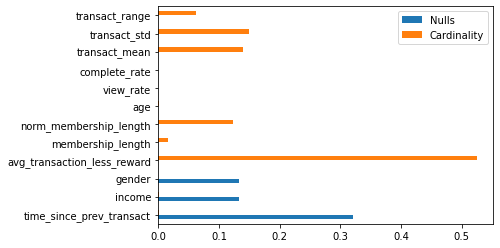

In [132]:
DEMOGRAPHIC_COLS = [
    'membership_length',
    'norm_membership_length',
    'age',
    'income',
    'gender',
]

SPENDING_COLS = [
    'time_since_prev_transact',
    'view_rate',
    'complete_rate',
    'transact_mean',
    'transact_std',
    'transact_range'
]

COLS_OF_INTEREST = (
    ['avg_transaction_less_reward'] 
    + DEMOGRAPHIC_COLS 
    + SPENDING_COLS
)

pd.merge(
    inputs_pre[COLS_OF_INTEREST].isna().mean().sort_values(ascending=False).rename('Nulls'),
    inputs_pre[COLS_OF_INTEREST].nunique().sort_values(ascending=False).rename('Cardinality') / len(inputs_pre),
    left_index=True,
    right_index=True,
).plot.barh()

We can see that:
- There are many inherent duplicates in our demographic data (age, gender, membership length, income), as we merged 109828 influence periods on a profile data of 17000 members. Similarly for <i>view_rate</i> and <i>complete_rate</i> as transactions data spans over 1 month only.
- More than 30% of data points have null <i>time_since_prev_transact</i>. These are influence periods with no previous transactions found.
- More than 10% of data points have missing <i>income</i> and/or <i>gender</i>, which poses a problem given our limited demographic features.

In [133]:
age_income_nulls = inputs_pre[inputs_pre[['age', 'income']].isna().any(axis=1)]

print(
    len(age_income_nulls), 
    "null entries corresponding to", 
    age_income_nulls['person'].nunique(), 
    "users, with unique (gender, age, income):",
    list(
        age_income_nulls.groupby(
            by=['gender', 'age', 'income']).groups.keys()
    ),
)

14199 null entries corresponding to 2085 users, with unique (gender, age, income): [(nan, 118, nan)]


We identify 14860 rows with null gender and income values, and nonsensical age of 118. There are little insights we can extract from these rows.

In [134]:
prev_transact_nulls = inputs_pre[inputs_pre['time_since_prev_transact'].isna()]
prev_transact_nulls.describe()

,start_time,end_time,amount,reward,age,income,membership_length,norm_membership_length,duration,avg_transaction_less_reward,time,time_since_prev_transact,view_rate,complete_rate,transact_mean,transact_std,transact_min,transact_max,transact_range
count,34395.000000,34395.000000,34395.000000,12270.000000,34395.000000,30112.000000,34395.000000,34395.000000,34395.000000,34395.000000,0.0,0.0,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000,34395.000000
mean,77.144876,229.911731,21.956501,4.440831,63.035732,67596.971307,1322.113534,0.152112,6.366331,14.589091,NaN,NaN,0.790117,0.450483,14.881662,7.739610,8.282463,32.241745,23.959282
std,130.006212,185.015735,52.584664,3.568006,26.099461,21648.999557,398.776773,0.315600,6.226121,198.156031,NaN,NaN,0.220249,0.336030,16.859886,27.198106,7.512047,83.543407,82.499988
min,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.041667,-240.000000,NaN,NaN,0.000000,0.000000,0.050000,0.000000,0.050000,0.050000,0.000000
25%,0.000000,72.000000,0.000000,2.000000,47.000000,51000.000000,1053.000000,0.053689,1.500000,0.000000,NaN,NaN,0.666667,0.166667,3.420000,1.818605,0.890000,7.635000,5.050000
50%,6.000000,180.000000,7.350000,3.000000,59.000000,66000.000000,1473.000000,0.086301,4.500000,0.821449,NaN,NaN,0.800000,0.500000,14.126250,3.591399,7.260000,21.040000,10.630000
75%,114.000000,348.000000,24.345000,5.000000,73.000000,83000.000000,1619.000000,0.128617,8.250000,5.246667,NaN,NaN,1.000000,0.750000,21.510286,5.699595,13.890000,30.340000,17.540000
max,696.000000,714.000000,1222.600000,10.000000,118.000000,120000.000000,1823.000000,4.991781,29.750000,20676.240000,NaN,NaN,1.000000,1.000000,451.470000,445.146568,50.080000,1062.280000,1036.330000


In [135]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

C:\Users\congr\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


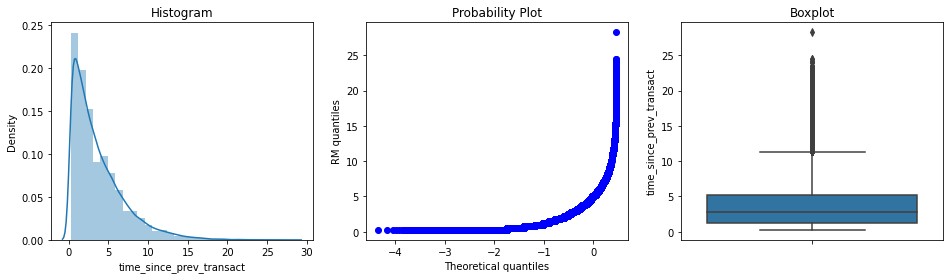

In [136]:
diagnostic_plots(inputs_pre, 'time_since_prev_transact')

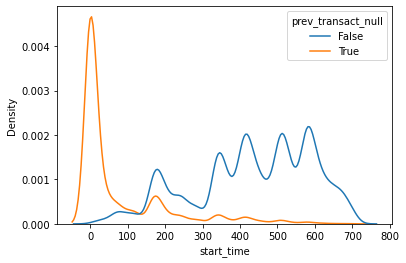

In [137]:
inputs_pre['prev_transact_null'] = np.where(inputs_pre['time_since_prev_transact'].isna(), True, False)

ax = sns.kdeplot(
    data=inputs_pre, 
    x='start_time',
    hue='prev_transact_null',
)

The large number of null <i>time_since_prev_transact</i> calls for missing data imputation to be performed. Most null <i>time_since_prev_transact</i> occurs at influence periods towards the start of the experiment (a case of cold start). It becomes imperative for us to impute these nulls with an appropriate value, keeping in mind that due to experiment design, <i>time_since_prev_transact</i> is inherently capped at 714.

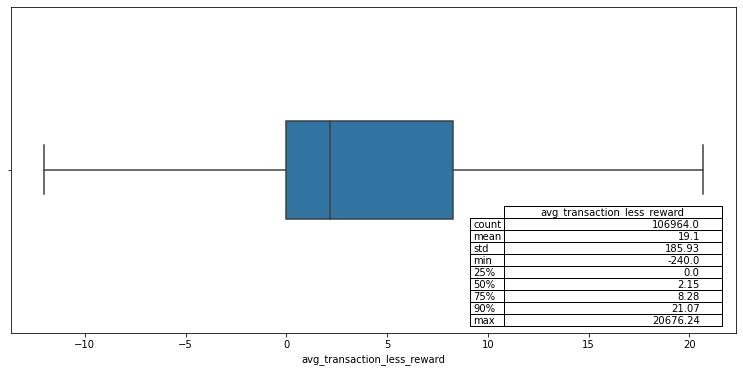

In [138]:
from pandas.plotting import table

fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax = sns.boxplot(
    ax=ax,
    x="avg_transaction_less_reward", 
    data=inputs_pre,
    showfliers=False,
    width=0.3,
)
table(
    ax, 
    np.round(
        inputs_pre['avg_transaction_less_reward'].describe(percentiles=[.25, .5, .75, .9]),
        2,
    ), 
    loc="lower right", 
    colWidths=[0.3, 0.2, 0.2]
)

((array([-4.36077361, -4.16263883, -4.05489471, ...,  4.05489471,
          4.16263883,  4.36077361]),
  array([ -240.  ,  -240.  ,  -240.  , ..., 18780.96, 19954.8 , 20676.24])),
 (42.833867334593705, 19.098904792962465, 0.23036379879308852))

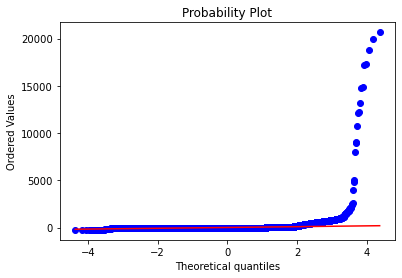

In [139]:
stats.probplot(inputs_pre['avg_transaction_less_reward'], dist="norm", plot=plt)

A boxplot of our target variable reveals that there are outliers bearing absurdly high positive values (a maximum of \\$20676.24/day when the 90th percentile is a mere \\$21.07/day). It is likely that these data points are associated with a very short influence period interval. Even though they represent successful offers pushed, these will need to be accounted for during data scaling to improve our model.

In [140]:
y_outliers = inputs_pre[inputs_pre['avg_transaction_less_reward'] > np.percentile(inputs_pre['avg_transaction_less_reward'], 99)]
y_outliers

,start_time,end_time,offer_id,person,amount,reward,gender,age,became_member_on,income,...,time,time_since_prev_transact,view_rate,complete_rate,transact_mean,transact_std,transact_min,transact_max,transact_range,prev_transact_null
77,168,168.0,fafdcd668e3743c1bb461111dcafc2a4,936c6f2b0024490d947611e446bac46e,20.89,2.0,F,67,2017-06-08,75000.0,...,66.0,4.25,0.600000,0.400000,18.041667,6.060232,10.42,25.64,15.22,False
387,0,0.0,no_offer,93afa7690b4545beaa80d6137191a204,20.95,NaN,F,57,2015-11-03,71000.0,...,NaN,NaN,1.000000,0.833333,18.153333,4.567496,11.25,25.03,13.78,True
763,522,540.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9250d51a392f4f2691eabff6851dcf66,459.13,5.0,F,60,2016-11-28,67000.0,...,NaN,NaN,0.500000,0.500000,124.337500,193.298632,10.33,459.13,448.80,True
965,234,234.0,f19421c1d4aa40978ebb69ca19b0e20d,92a48c2edfba4764bf59bfe70023e461,26.13,5.0,M,58,2018-05-31,66000.0,...,114.0,5.00,1.000000,0.666667,14.789167,5.471151,6.94,26.13,19.19,False
1226,336,336.0,4d5c57ea9a6940dd891ad53e9dbe8da0,293cbd7d0073404b9b1a05ee27da4745,47.02,10.0,F,59,2017-08-09,96000.0,...,138.0,8.25,1.000000,1.000000,32.064167,9.649557,18.83,52.85,34.02,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106717,342,342.0,fafdcd668e3743c1bb461111dcafc2a4,c91e7cea9dad4b5c8b2f6167a6827201,25.86,2.0,F,61,2016-01-06,115000.0,...,174.0,7.00,0.750000,0.750000,29.034286,6.788052,16.80,39.18,22.38,False
106718,534,534.0,2298d6c36e964ae4a3e7e9706d1fb8c2,c91e7cea9dad4b5c8b2f6167a6827201,29.93,3.0,F,61,2016-01-06,115000.0,...,480.0,2.25,0.750000,0.750000,29.034286,6.788052,16.80,39.18,22.38,False
106747,618,618.0,f19421c1d4aa40978ebb69ca19b0e20d,c391f36b80484cdeab41cb227a862fef,24.69,5.0,F,53,2016-05-21,87000.0,...,522.0,4.00,1.000000,1.000000,25.349000,7.304651,13.18,39.63,26.45,False
106764,174,174.0,f19421c1d4aa40978ebb69ca19b0e20d,c89d7d9465644288b43bd4d0cce1622e,28.17,5.0,F,53,2016-02-13,109000.0,...,NaN,NaN,1.000000,1.000000,28.311429,9.210209,22.43,50.41,27.98,True


In [141]:
y_outliers[[
    'amount', 
    'avg_transaction_less_reward', 
    'age', 
    'income', 
    'membership_length',
    'duration',
]].agg(['max', 'min', 'mean'])

,amount,avg_transaction_less_reward,age,income,membership_length,duration
max,1015.730000,20676.240000,118.000000,120000.000000,1815.000000,2.250000
min,17.770000,424.800000,19.000000,31000.000000,39.000000,0.041667
mean,70.666891,812.468861,59.346442,84058.270677,1192.318352,0.083880


In actual fact, these 'outliers' all consists of influence periods spanning less than a day, with aggregated transactions ranging from just \\$17 to \\$1015. Although these are acceptable given that bulk orders do exist and we already decided to keep short offer periods in our input, there will be a need to normalize our dependant variable prior to training our model.

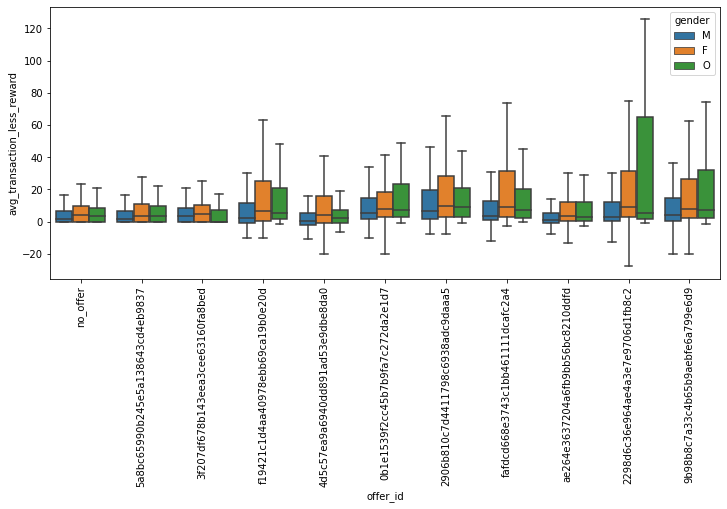

In [142]:
ax = sns.boxplot(
    x="offer_id", 
    y="avg_transaction_less_reward", 
    hue="gender",
    data=inputs_pre,
    showfliers=False,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_size_inches(12, 5)

Boxplots split by genders and grouped by offers enable us to observe effects of different offers on our target variable. There is no offer that increases <i>avg_transaction_less_reward</i> for the vast majority, although there are some offers that brings improvement to some people, spreading out the distribution in our desired direction. It is also important to note that some offers incurred the undesired effect of bringing <i>avg_transaction_less_reward</i> into the negatives. These are our identified areas of improvement on the choice of offers pushed out to users.

<p>
    Next, we would want to explore the distributions of demographic variables of the users. A pair plot is a good visualization tool to summarise the uni-variate and pair-wise distributions of demographic variables as well as our dependant variable. We select a density plot due to the large nature of our dataset.
</p>
<p>
    <b>WARNING</b>: Plot might take awhile to render.
</p>

Wall time: 1.72 s


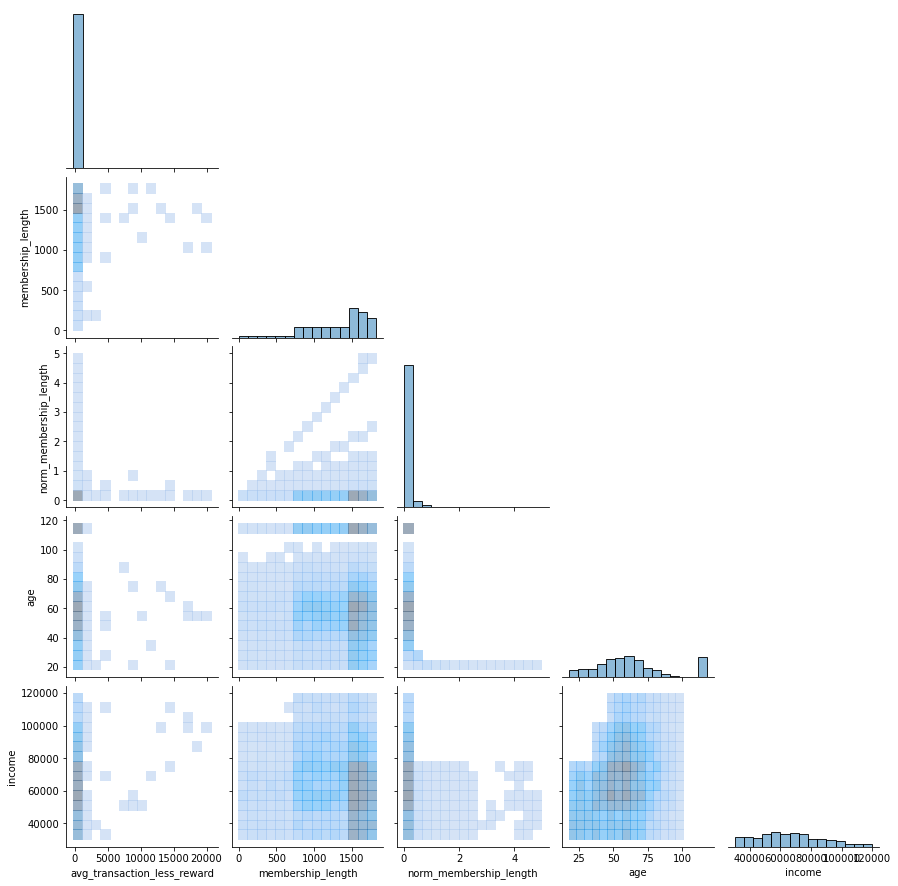

In [143]:
%%time

sns.pairplot(
    inputs_pre[['avg_transaction_less_reward'] + DEMOGRAPHIC_COLS], 
    kind='hist',
    diag_kws={'alpha':0.5, 'bins':15},
    plot_kws={'alpha':0.5, 'bins':15},
    corner=True,
)

From the density pairplot between demographic variables, we can identify some vague patterns between our variables, such as:
1. Outliers in <i>avg_transaction_less_reward</i>.
2. Oddities in the <i>age</i> distribution where a large number of data points have ages exceeding 100 years old.
3. A large portion of long-running members are mid-income and between 40 to 60 years old.
4. We vaguely observe that larger <i>avg_transaction_less_reward</i> tends to come from longer-running members, higher income, and older age.

Wall time: 3.47 s


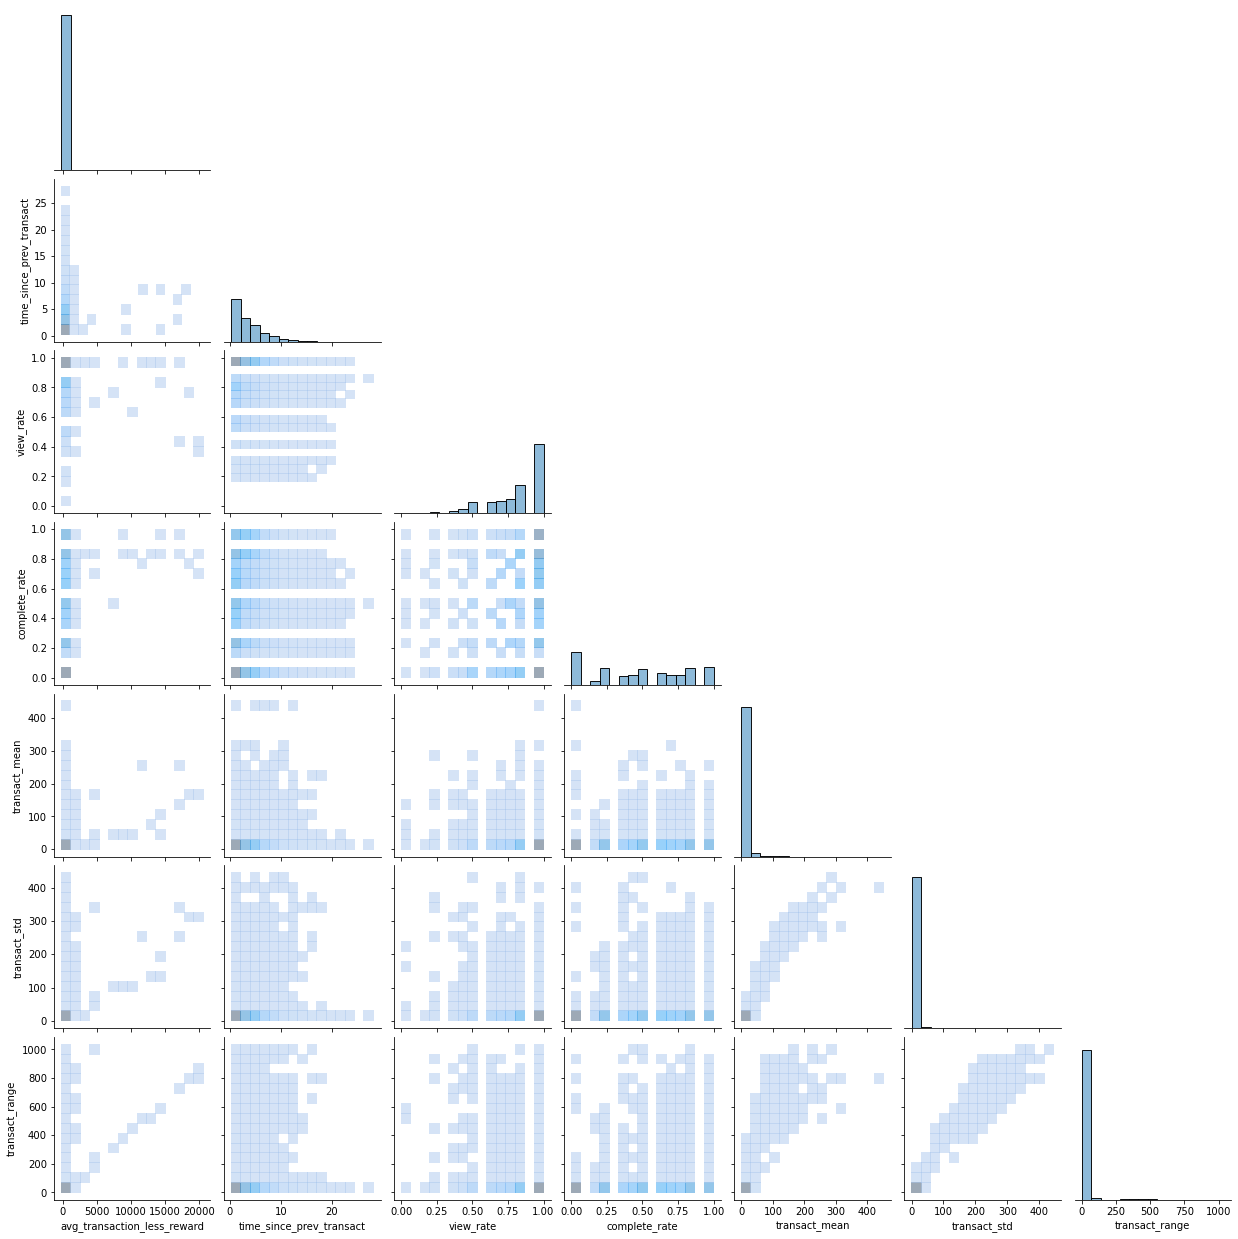

In [144]:
%%time

sns.pairplot(
    inputs_pre[['avg_transaction_less_reward'] + SPENDING_COLS], 
    kind='hist',
    diag_kws={'alpha':0.5, 'bins':15},
    plot_kws={'alpha':0.5, 'bins':15},
    corner=True,
)

From the density pairplot between spending, we can further identify:
1. <i>transact_mean</i>, <i>transact_std</i> and <i>transact_range</i> have skewed distributions similar to <i>avg_transaction_less_reward</i>.
2. <i>transact_mean</i>, <i>transact_std</i> and <i>transact_range</i> have strong positive correlation with <i>avg_transaction_less_reward</i>. Exception being influence periods with small <i>avg_transaction_less_reward</i> values.

However, density plots are by no means a good visualization to spot patterns. We plot a correlation heatmap instead to ascertain the variables' pair-wise correlation.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, 'avg_transaction_less_reward'),
  Text(0, 1.5, 'membership_length'),
  Text(0, 2.5, 'norm_membership_length'),
  Text(0, 3.5, 'age'),
  Text(0, 4.5, 'income'),
  Text(0, 5.5, 'time_since_prev_transact'),
  Text(0, 6.5, 'view_rate'),
  Text(0, 7.5, 'complete_rate'),
  Text(0, 8.5, 'transact_mean'),
  Text(0, 9.5, 'transact_std'),
  Text(0, 10.5, 'transact_range')])

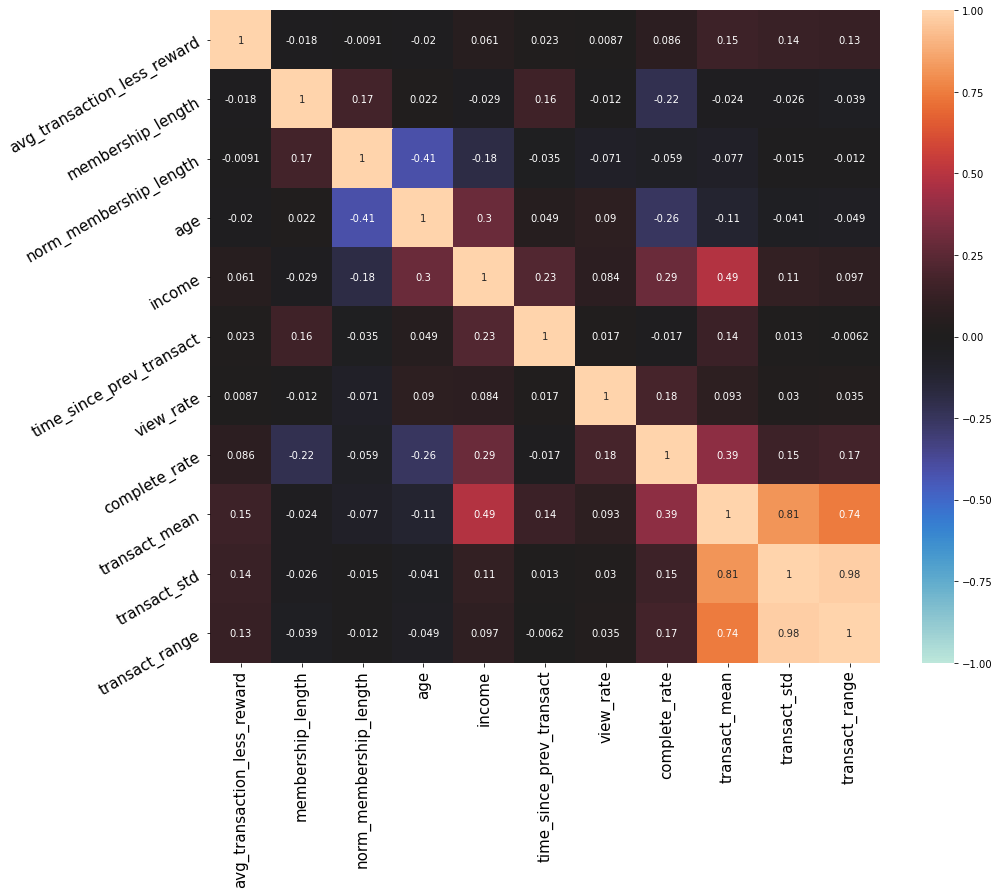

In [145]:
fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(
    inputs_pre[COLS_OF_INTEREST].corr(), 
    center=0, 
    vmin=-1, 
    vmax=1, 
    annot=True,
    ax=ax,
)

plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=30, fontsize=15)

<p>
    There are no single variable which correlates strongly with the predicted variable. This leads us to think that simple linear regression may not fare well in this case, and a more sophisticated machine learning algorithm may be better suited to capture the nuances between the predicted variable and our limited features.
</p>
<p>
    In addition, the transaction aggregates display strong correlation among each other. Hence, we may need to perform feature selection to prevent colinearity from impeding our models.
</p>